[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3182 - loss: 1.9041 - val_accuracy: 0.3380 - val_loss: 1.7807
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3892 - loss: 1.6747 - val_accuracy: 0.3380 - val_loss: 1.7177
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4270 - loss: 1.4468 - val_accuracy: 0.3380 - val_loss: 1.6508
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4530 - loss: 1.2596 - val_accuracy: 0.3662 - val_loss: 1.6197
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6727 - loss: 0.9323 - val_accuracy: 0.3944 - val_loss: 1.6357
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8908 - loss: 0.5729 - val_accuracy: 0.4085 - val_loss: 1.7157
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9895 - loss: 0.2454 - val_accuracy: 0.4366 - val_loss: 1.8531
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9961 - loss: 0.1094 - val_accuracy: 0.4366 - v

C:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

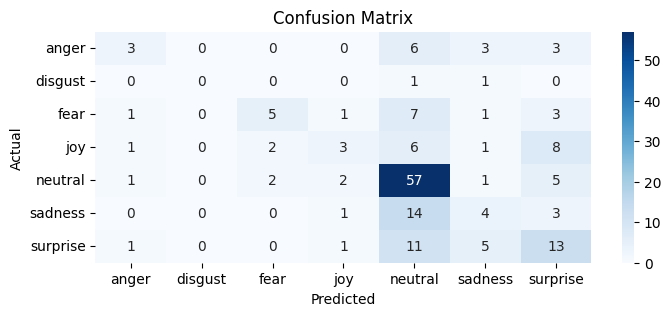

Model saved to C:\Users\adria\OneDrive\Documents\emotion_nn_classifier_model.h5
Vectorizer saved to C:\Users\adria\OneDrive\Documents\tfidf_vectorizer.pkl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predictions for new comments: ['joy', 'sadness']
Average Polarity: 0.08267899764941607
Average Subjectivity: 0.38484241065410985
Conclusion: Overall positive sentiment
Emotion Distribution:
Emotion
neutral     351
surprise    140
sadness     121
joy         100
fear         85
anger        84
disgust       3
Name: count, dtype: int64
Emotion Percentages:
Emotion
neutral     39.705882
surprise    15.837104
sadness     13.687783
joy         11.312217
fear         9.615385
anger        9.502262
disgust      0.339367
Name: count, dtype: float64
Emotion detection and sentiment analysis have been written to 'C:\Users\adria\OneDrive\Documents\reddit_post_comments_with_emotions_and_sentiments.xlsx'


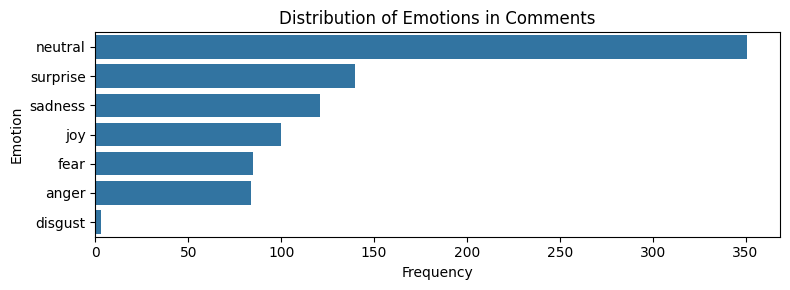

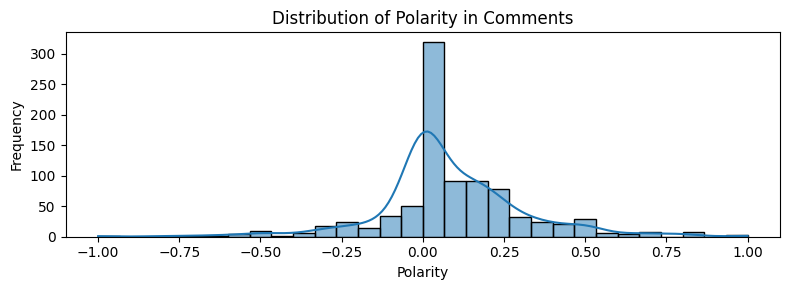

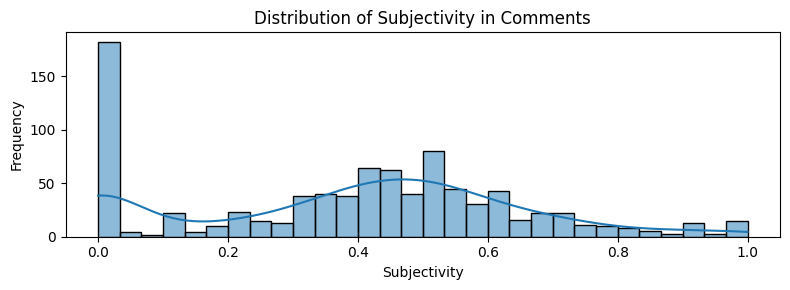

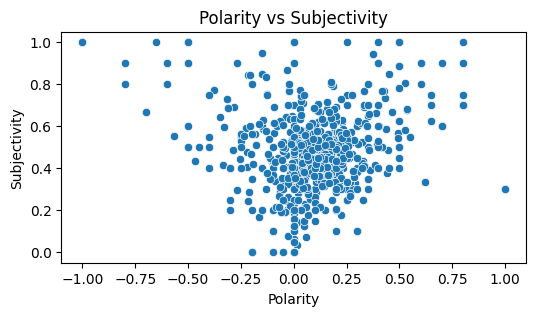

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
import numpy as np
import joblib

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
input_path = r'C:\Users\adria\OneDrive\Documents\reddit_comments_combined.xlsx'
df = pd.read_excel(input_path, sheet_name='Comments')

# Function to preprocess the text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = word_tokenize(text)  # Tokenize
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()  # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply preprocessing to the comment body
df['Cleaned Comment'] = df['Comment Body'].apply(preprocess_text)

# Load the pre-trained emotion detection model and tokenizer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to perform emotion detection
def detect_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return torch.argmax(probs, dim=1).item(), probs

# Apply emotion detection to each cleaned comment
emotions = []
for comment in df['Cleaned Comment']:
    label, probs = detect_emotion(comment)
    emotions.append(label)

# Map the numerical labels to emotion categories
emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
df['Emotion'] = [emotion_labels[label] for label in emotions]

# Define functions to compute polarity and subjectivity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Apply polarity and subjectivity analysis
df['Polarity'] = df['Cleaned Comment'].apply(get_polarity)
df['Subjectivity'] = df['Cleaned Comment'].apply(get_subjectivity)

# Encode the target variable
label_encoder = LabelEncoder()
df['Emotion Label'] = label_encoder.fit_transform(df['Emotion'])

# Prepare the data for training
X = df['Cleaned Comment']
y = df['Emotion Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Get the actual number of features
input_dim = X_train_tfidf.shape[1]

# Convert the labels to categorical format
y_train_cat = to_categorical(y_train, num_classes=len(emotion_labels))
y_test_cat = to_categorical(y_test, num_classes=len(emotion_labels))

# Build a neural network model
nn_model = Sequential()
nn_model.add(Input(shape=(input_dim,)))  # Set the input shape dynamically
nn_model.add(Dense(512, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(len(emotion_labels), activation='softmax'))

nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = nn_model.fit(X_train_tfidf.toarray(), y_train_cat, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model
y_pred_prob = nn_model.predict(X_test_tfidf.toarray())
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=emotion_labels))
print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Visualization of the confusion matrix
plt.figure(figsize=(8, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the trained model and vectorizer
nn_model_path = r'C:\Users\adria\OneDrive\Documents\emotion_nn_classifier_model.h5'
vectorizer_path = r'C:\Users\adria\OneDrive\Documents\tfidf_vectorizer.pkl'
nn_model.save(nn_model_path)
joblib.dump(vectorizer, vectorizer_path)
print(f'Model saved to {nn_model_path}')
print(f'Vectorizer saved to {vectorizer_path}')

# Predicting new data
new_comments = ["I love the technology, it makes my job easier!", "I just lost my job."]
new_comments_cleaned = [preprocess_text(comment) for comment in new_comments]
new_comments_tfidf = vectorizer.transform(new_comments_cleaned)
new_predictions_prob = nn_model.predict(new_comments_tfidf.toarray())
new_predictions = [emotion_labels[np.argmax(pred)] for pred in new_predictions_prob]
print(f'Predictions for new comments: {new_predictions}')

# Conclusion on sentiment
polarity_mean = df['Polarity'].mean()
subjectivity_mean = df['Subjectivity'].mean()

print(f"Average Polarity: {polarity_mean}")
print(f"Average Subjectivity: {subjectivity_mean}")

if polarity_mean > 0:
    sentiment_conclusion = "Overall positive sentiment"
elif polarity_mean < 0:
    sentiment_conclusion = "Overall negative sentiment"
else:
    sentiment_conclusion = "Neutral sentiment"

print(f"Conclusion: {sentiment_conclusion}")

# Conclusion emotion analysis
emotion_counts = df['Emotion'].value_counts()
print("Emotion Distribution:")
print(emotion_counts)

# Determining the percentage of each emotion
emotion_percentages = (emotion_counts / len(df)) * 100
print("Emotion Percentages:")
print(emotion_percentages)

# Save the results to a new Excel file
output_path = r'C:\Users\adria\OneDrive\Documents\reddit_post_comments_with_emotions_and_sentiments.xlsx'
with pd.ExcelWriter(output_path) as writer:
    df.to_excel(writer, sheet_name='Comments', index=False)

print(f"Emotion detection and sentiment analysis have been written to '{output_path}'")

# Visualization
plt.figure(figsize=(8, 3))

# Distribution of emotions
sns.countplot(y='Emotion', data=df, order=df['Emotion'].value_counts().index)
plt.title('Distribution of Emotions in Comments')
plt.xlabel('Frequency')
plt.ylabel('Emotion')

plt.tight_layout()
plt.show()

# Distribution of polarity
plt.figure(figsize=(8, 3))
sns.histplot(df['Polarity'], bins=30, kde=True)
plt.title('Distribution of Polarity in Comments')
plt.xlabel('Polarity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Distribution of subjectivity
plt.figure(figsize=(8, 3))
sns.histplot(df['Subjectivity'], bins=30, kde=True)
plt.title('Distribution of Subjectivity in Comments')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scatter plot of polarity vs subjectivity
plt.figure(figsize=(6, 3))
sns.scatterplot(x='Polarity', y='Subjectivity', data=df)
plt.title('Polarity vs Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [9]:
#Predicting new comment
new_comments = ["I have no idea about it", "It sucks."]
new_comments_cleaned = [preprocess_text(comment) for comment in new_comments]
new_comments_tfidf = vectorizer.transform(new_comments_cleaned)
new_predictions_prob = nn_model.predict(new_comments_tfidf.toarray())
new_predictions = [emotion_labels[np.argmax(pred)] for pred in new_predictions_prob]
print(f'Predictions for new comments: {new_predictions}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predictions for new comments: ['neutral', 'sadness']
